In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Env:
  def step(self, a):
    pass
  def get_q_star(self):
    pass

class Agent:
  def pick_action(self):
    pass
  def update_q(self, a, r):
    pass

In [ ]:
class BanditsEnv(Env):
  def __init__(self, num_arms):
    self.q_star = np.random.normal(loc=0, scale=1, size=num_arms)

  def step(self, a):
    return np.random.normal(loc=self.q_star[a])

  def get_q_star(self):
    return self.q_star

In [ ]:
class BanditsAgent(Agent):
  def __init__(self, arms, algo="e-greedy", eps=0.1, q_init=0.0, c=1.0, alpha=0.1):
    self.eps = eps
    self.arms = arms
    self.q = np.full(arms, q_init)
    self.N = np.zeros(arms)
    self.c = c
    self.t = 0
    self.H = np.zeros(arms)
    self.alpha = alpha
    self.r_bar = 0
    self.p_a = np.zeros(arms)

    action_selection_map = {
        "greedy": self.greedy,
        "e-greedy": self.epsilon_greedy,
        "ucb": self.ucb,
        "gradient": self.gradient
    }
    self.select_action = action_selection_map.get(algo, None) # Replace None with something else later
  
  def pick_action(self):
    self.t += 1
    return self.select_action()

  def update_q(self, a, r):
    self.N[a] += 1

    if self.select_action == self.gradient:
      index = np.zeros(arms)
      index[a] = 1

      self.r_bar = r if self.t==1 else self.r_bar + (r - self.r_bar)/(self.t)
      self.H = self.H + self.alpha*(r-self.r_bar)*(index-self.p_a)
    else:
      self.q[a] = self.q[a] + (r-self.q[a])/(self.N[a])

  # Action selection algorithms
  def greedy(self):
    return np.argmax(self.q)
  def epsilon_greedy(self):
    return np.argmax(self.q) if np.random.random() > self.eps else np.random.randint(0, high=self.arms)
  def ucb(self):
    return np.argmax(self.q + self.c*np.sqrt(np.log(self.t)/(self.N + 1)))
  def gradient(self):
    self.p_a = self.softmax(self.H)
    return np.random.choice(np.arange(self.arms), p=self.p_a)

  # Helper functions
  def softmax(self, x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

In [ ]:
class Logger:
  def __init__(self):
    self.acc_list = []
    self.r_list = []

  def add_acc(self, acc):
    if len(self.acc_list) == 0:
      self.acc_list.append(acc)
    else:
      self.acc_list.append(self.acc_list[-1] + (acc - self.acc_list[-1])/(len(self.acc_list)+1))

  def add_reward(self, r):
    if len(self.r_list) == 0:
      self.r_list.append(r)
    else:
      self.r_list.append(self.r_list[-1] + (r - self.r_list[-1])/(len(self.r_list)+1))
  
  def get_accs(self):
    return self.acc_list

  def get_rs(self):
    return self.r_list

In [ ]:
class System:
  def __init__(self, env:Env, agent:Agent, logger:Logger):
    self.env = env
    self.agent = agent
    self.logger = logger

  def run(self, steps):
    q_star = self.env.get_q_star()

    for t in range(steps):
      a = self.agent.pick_action()
      r = self.env.step(a)
      self.agent.update_q(a, r)
    
      acc = (a == np.argmax(q_star))*1
      self.logger.add_acc(acc)
      self.logger.add_reward(r)
  
  def get_env(self):
    return self.env

  def get_agent(self):
    return self.agent

  def get_logger(self):
    return self.logger

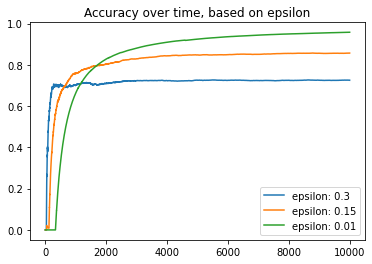

In [ ]:
# Compare values of epsilon
arms = 10
T = 10000

bandits = BanditsEnv(arms)

eps = [0.3, 0.15, 0.01]
for e in eps:
  agent = BanditsAgent(arms, algo="e-greedy", eps=e)
  logger = Logger()
  system = System(bandits, agent, logger)
  system.run(T)
  plt.plot(system.get_logger().get_accs(), label="epsilon: " + str(e))

plt.legend()
plt.title("Accuracy over time, based on epsilon")
plt.show()

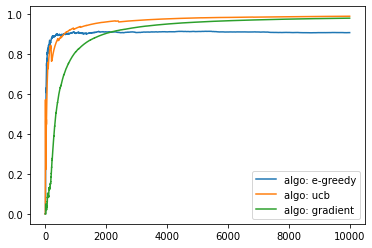

In [ ]:
# Compare algorithms. Takes ~20 seconds to run
arms = 10
T = 10000

bandits = BanditsEnv(arms)

algos = ["e-greedy", "ucb", "gradient"]
for algo in algos:
  agent = BanditsAgent(arms, algo=algo)
  logger = Logger()
  system = System(bandits, agent, logger)
  system.run(T)
  plt.plot(system.get_logger().get_accs(), label="algo: " + algo)
  plt.legend()

plt.show()